# <u>Neural/AI Search applied to Proxy Logs</u>

The intention of this Jupyter notebook is to examine how we might apply AI search to security logs.  We'll be using fabricated proxy logs that (in theory) show benign behavior, malicious behavior, and a 950/50 mix of those two. You will find demonstrations of the following three examples:
- <u>Exploit Matching</u>: Compare unknown or incoming logs to a vector DB of known malicious logs, flagging matches above a threshold for alert.
- <u>Anomaly Detection</u>: Compare unknown or incoming logs to a vector DB of known benign logs, flagging possible anomalies below a matching threshold for alert.
- <u>Semantic Clustering</u>: Examples of clustering analysis done with full text by leveraging those vector embeddings...essentially clustering on semantic meaning of the text event logs.

Any of these approaches could be applied to flagging/alerting processes on incoming event logs, or applied to threat-hunting within existing log data, or anything in between. One of the big benefits is that query, analysis, etc., can be done without needing to parse logs into fields of tabular data. Leveraging vector embeddings helps capture the meaning of the logs, rather than just discrete pieces of data from them.

In terms of the tech stack, we'll be using <b><u>two key components</b></u>:
- <u>Vector datastore</u>: A simple development-grade vector datastore called ChromaDB
- <u>Embedding model</u>: A locally-run HuggingFace sentence transformer model (all-MiniLM-L6-v2) that's a common choice for calculating vector embeddings of general-purpose text.
Note that these two technology choices make this demonstration completely self-contained...<b>no data is being transmitted out to any external internet service, nor any data being brought back in from an external source</b>.

Note that there are many synonyms for <b><u>vector search</u></b>...here's a list:
- Vector similarity search
- Semantic similarity search
- Neural search (because of it's basis in neural network models for the embeddings)
- AI search
- Cognitive search
- KNN search (K-Nearest Neighbors...this is the traditional conceptual name)
- ANN search (Approximate Nearest Neighbors) 
- HNSW (Hierarchical Navigable Small World) search (the most popular approximation algorithm)
- Probably a few others I don't remember at the moment

All of these synonyms are referring to the same concepts and technology. It's worth noting that vector search technology has been used in large scale recommendation systems, fraud detection systems, and other "big data" types of applications for nearly a decade. In fact, handling very large volumes of full-text data is exactly what this technology was invented to handle. It's also worth noting that vector embeddings are not just relevant to text...given a suitable ML model, vector embeddings can be captured for images, audio, video, even binary executables and encrypted data. 

<b><u>Where does vector search fit into the big picture?</u></b>  There are essentially three categories of "search":
- Relational query: Search on value equalities and ranges of data...very deterministic
- Full-text/keyword search:  Query on word matches, including compressed word stems...more fuzzy/stochastic
- Vector semantic search: Query on meanings of text passages rather than keywords...very stochastic

In [ ]:
### Uncomment and run the line below if this is the first time executing this notebook. Package installs in requirements.txt.
#! python -m venv venv
#! powershell venv\Scripts\Activate.ps1
#! pip install -r .\requirements.txt --force


In [1]:
import os, sys
import pandas as pd 
import chromadb
#from chromadb.config import DEFAULT_TENANT, DEFAULT_DATABASE, Settings

# <u>Exploit Matching</u>: AI search with new logs
## Step 1: Hydrate vector DB with malicious logs
We can use this vectorstore of known malicious logs as reference data to compare incoming logs against to determine if any of those events are similar enough to raise an alert.  

In [2]:
# This CSV file contains fabricated proxy logs that are examples of malicious activity attempts
df = pd.read_csv('proxy_logs_malicious.csv')
df.columns

Index(['ID', 'IP Address', 'Timestamp', 'Log Entry'], dtype='object')

In [3]:
df.sample(3) # I've purposefully generated these to look like something that might be extracted from Splunk

,ID,IP Address,Timestamp,Log Entry
225,226,178.42.62.152,01/Aug/2024:00:41:32,GET http://www.example.com/search?q=<script>al...
460,461,167.242.199.33,01/Aug/2024:13:10:00,GET http://www.example.com/index.php?page=../....
130,131,249.34.238.2,01/Aug/2024:19:56:37,GET http://www.example.com/login.php?user=admi...


In [4]:
# setup Chroma in-memory, for easy prototyping. Can add persistence easily!
client = chromadb.Client()
#client = chromadb.PersistentClient(path='./chromadb_proxy_logs')  # A bug prevents this from working

# Create collection. get_collection, get_or_create_collection, delete_collection also available
# ChromaDB uses L2 (Euclidean distance) by default...we want Cosine metric.
# Cosine similarity -> higher = better
vectordb = client.get_or_create_collection(name='malicious_proxy_logs', metadata={"hnsw:space": "cosine"})

In [5]:
# Add docs to the vectordb collection. Can also update and delete.

# Create lists of the necessary data from the dataframe
ID_list = df['ID'].astype(str).tolist()  # ID list, converted to string
LogEntry_list = df['Log Entry'].tolist()   # List of documents (log content)

# We are letting ChromaDB automatically calculate the vector embedding, instead of explicitly handling it
# By default, ChromaDB uses all-MiniLM-L6-v2 sentence transformer model to calculate vector embeddings
# This all-MiniLM-L6-v2 model provides a 384 dimension vector that can be used for embedding and clustering
vectordb.add(
    documents=LogEntry_list, # we handle tokenization, embedding, and indexing automatically. You can skip that and add your own embeddings as well
    #metadatas=[{"source": "notion"}, {"source": "google-docs"}], # metadata filters
    ids=ID_list, # unique ID for each doc
)

In [6]:
vectordb.count()  # Check our count to make sure it looks right

1000

In [7]:
# Examine a record by ID...tell it to show the vector embedding so we can see what it looks like
# The vector embedding is the 384 dimension numeric representation of what that text "means"...
vectordb.get('1', include=['embeddings', 'documents', 'metadatas'])
#vectordb.get(['1','2'], include=['embeddings', 'documents', 'metadatas'])

{'ids': ['1'],
 'embeddings': [[0.007624867372214794,
   0.045366719365119934,
   -0.04748733714222908,
   0.0063828821294009686,
   0.1047120913863182,
   -0.0929495170712471,
   0.0033019226975739002,
   -0.025921089574694633,
   0.05312323942780495,
   -0.09988000988960266,
   -0.013496407307684422,
   0.025275133550167084,
   0.09099344909191132,
   -0.0023014703765511513,
   -0.036896415054798126,
   0.02726397104561329,
   -3.0865496228216216e-05,
   0.01758955605328083,
   0.04421308636665344,
   -0.04823216423392296,
   0.09137730300426483,
   0.03763030469417572,
   0.04211864247918129,
   -0.008693178184330463,
   -0.07841534167528152,
   -0.042019568383693695,
   -0.03711337968707085,
   -0.01432881411164999,
   0.03943726047873497,
   0.0070097967982292175,
   0.04297931492328644,
   -0.13454097509384155,
   0.014948688447475433,
   -0.010114735923707485,
   0.006748182699084282,
   -0.02621455118060112,
   0.02079353854060173,
   0.00518131535500288,
   0.01601628586649894

In [10]:
# Execute an ANN query/search for K most similar results.
results = vectordb.query(
    query_texts=["http://www.example.com/../../etc/passwd"], # This gets vectorized and used for vector query
    n_results=3,
    # where_document={"$contains":"Macintosh"}  # optional keyword filter
    # where_document={"$contains":"Windows NT"}  # optional keyword filter
    # where={"metadata_field": "is_equal_to_this"}, # optional metadata filter
)

results

{'ids': [['660', '42', '103']],
 'distances': [[0.37813329696655273,
   0.38311660289764404,
   0.38322436809539795]],
 'metadatas': [[None, None, None]],
 'embeddings': None,
 'documents': [['GET http://www.example.com/../../etc/passwd HTTP/1.1" 500 322256 "http://www.example.com/../../etc/passwd" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15',
   'GET http://www.example.com/index.php?page=../../../../../../etc/passwd HTTP/1.1" 400 665698 "http://www.example.com/index.php?page=../../../../../../etc/passwd" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15',
   'GET http://www.example.com/index.php?page=../../../../../../etc/passwd HTTP/1.1" 400 2953 "http://www.example.com/index.php?page=../../../../../../etc/passwd" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15']],
 

In [11]:
# Ask the same question, but this time in natural language
results = vectordb.query(
    query_texts=["Can you show me possible attempts to change a password?"],  # Vectorize and search
    n_results=3,
    # where_document={"$contains":"script"}  # optional keyword filter
    # where={"metadata_field": "is_equal_to_this"}, # optional metadata filter
)

results

{'ids': [['730', '573', '153']],
 'distances': [[0.6075342893600464, 0.611862063407898, 0.6151670813560486]],
 'metadatas': [[None, None, None]],
 'embeddings': None,
 'documents': [['GET http://www.example.com/index.php?page=../../../../../../etc/passwd HTTP/1.1" 403 580156 "http://www.example.com/index.php?page=../../../../../../etc/passwd" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15',
   'GET http://www.example.com/index.php?page=../../../../../../etc/passwd HTTP/1.1" 403 530538 "http://www.example.com/index.php?page=../../../../../../etc/passwd" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15',
   'GET http://www.example.com/index.php?page=../../../../../../etc/passwd HTTP/1.1" 403 190296 "http://www.example.com/index.php?page=../../../../../../etc/passwd" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, l

In [12]:
# Ask a less specific question, again in natural language
results = vectordb.query(
    query_texts=["Please show me possible intrusion attempts"],  # Vectorize and search
    n_results=3,
    # where_document={"$contains":"script"}  # optional keyword filter
    # where={"metadata_field": "is_equal_to_this"}, # optional metadata filter
)

results

{'ids': [['771', '332', '613']],
 'distances': [[0.7482555508613586, 0.7587827444076538, 0.777846097946167]],
 'metadatas': [[None, None, None]],
 'embeddings': None,
 'documents': [['GET http://www.example.com/index.php?page=../../../../../../etc/passwd HTTP/1.1" 403 802029 "http://www.example.com/index.php?page=../../../../../../etc/passwd" "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.5112.81 Safari/537.36',
   'GET http://www.example.com/index.php?page=../../../../../../etc/passwd HTTP/1.1" 403 444400 "http://www.example.com/index.php?page=../../../../../../etc/passwd" "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.5112.81 Safari/537.36',
   'GET http://www.example.com/index.php?page=../../../../../../etc/passwd HTTP/1.1" 403 33197 "http://www.example.com/index.php?page=../../../../../../etc/passwd" "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome

We've built a vector datastore of known malicious logs...we can now use this to compare with logs of an unknown risk.

# Step 2: Semantic matching of malicious attempts
Using our vector DB of malicious logs to execute neural searches against, let's feed it some fresh logs to see what matches we get.  We want to use cosine similarity for this.  We'll have to experiment a bit to set a reasonable threshold for when to return an alert vs not.

In [13]:
# Some fabricated proxy logs that contain 950 benign log entries and 50 malicious log entries
df = pd.read_csv('proxy_logs_mixed.csv')

In [14]:
df.sample(3)

,ID,IP Address,Timestamp,Log Entry
156,157,31.111.33.28,01/Aug/2024:04:09:19,GET http://intranet.company.com/docs/document....
179,180,122.16.176.60,01/Aug/2024:00:10:34,GET http://intranet.company.com/docs/document....
737,738,244.23.36.245,01/Aug/2024:04:30:39,"GET http://update.software.com/check HTTP/1.1""..."


In [15]:
# Find incoming log entries that match known malicious activity at a pre-determined threshold 
incoming_proxy_logs = df['Log Entry']

for log_entry in incoming_proxy_logs:
    results = vectordb.query(
    query_texts=log_entry,
    n_results=1,
    # where={"metadata_field": "is_equal_to_this"}, # optional filter
    # where_document={"$contains":"Macintosh"}  # optional filter
    )
    if results['distances'][0][0] <= 0.001:  # Threshold for a match...this should be the wrong direction!
    #if results['distances'][0][0] >= 0.488:  # Threshold for a match
    # NOTE:  It appears that ChromaDB is using Euclidean distance even though I specified Cosine similarity
    #        Our best matches should be high values, not low values
       print(f'Score {results["distances"][0][0]}: {log_entry} \n -match ID {results["ids"][0]} content: {results["documents"][0][0]}')

Score 0.0003476142883300781: GET http://www.example.com/login.php?user=admin'-- HTTP/1.1" 500 418666 "http://www.example.com/login.php?user=admin'--" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15 
 -match ID ['754'] content: GET http://www.example.com/login.php?user=admin'-- HTTP/1.1" 500 598628 "http://www.example.com/login.php?user=admin'--" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15
Score 0.0005150437355041504: GET http://www.example.com/../../etc/passwd HTTP/1.1" 500 809539 "http://www.example.com/../../etc/passwd" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15 
 -match ID ['756'] content: GET http://www.example.com/../../etc/passwd HTTP/1.1" 500 963407 "http://www.example.com/../../etc/passwd" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.

We demonstrated here that we can do a vector search comparing incoming log records with a vector DB of known malicious log records, get the top reasonable matches, and do so without any drastic data manipulation. (This is after adjusting for ChromaDB's apparent malfunction with using the specified distance calcs, of course.) In fact, we <b><i>did not even parse any of the log content</i></b>, we just used the vector embeddings of that log content. We are doing semantic matching using the vector embeddings of the full text...this is the important item to take note of.  The data in this case are sets of fabricated proxy logs...this exercise needs to be examined with real logs. 

# <u>Anomaly Detection</u> by AI search on Benign Logs
## Step 1: Build vector DB of Benign Proxy log data
Now, let's build a vector DB from log data that is good rather than bad.

In [16]:
# To conserve memory, re-use the previous vectordb collection for new data
vectordb = client.get_or_create_collection(name='benign_proxy_logs', metadata={"hnsw:space": "cosine"})

In [17]:
# This CSV file contains fabricated proxy logs that are examples of benign activity
df = pd.read_csv('proxy_logs_good.csv')
df.sample(3)

,ID,IP Address,Timestamp,Log Entry
924,925,108.250.200.209,01/Aug/2024:07:45:36,"GET http://intranet.company.com/home HTTP/1.1""..."
89,90,122.11.169.236,01/Aug/2024:09:50:18,GET http://cloudstorage.com/authenticate HTTP/...
854,855,150.140.186.247,01/Aug/2024:13:42:23,"GET http://www.example.com/style.css HTTP/1.1""..."


In [18]:
# Create lists of the necessary data from the dataframe
ID_list = df['ID'].astype(str).tolist()  # ID list, converted to string
LogEntry_list = df['Log Entry'].tolist()   # List of documents (log content)

# Add log records to vector store, allowing ChromaDB to calculate vector embeddings
vectordb.add(
    documents=LogEntry_list, # we handle tokenization, embedding, and indexing automatically. 
    #metadatas=[{"source": "notion"}, {"source": "google-docs"}], # metadata filters
    ids=ID_list, # unique ID for each doc
)

In [19]:
vectordb.count()  # Check our count to make sure it looks right

1000

In [20]:
# Check a few records...
vectordb.get(['1','2','3'])

{'ids': ['1', '2', '3'],
 'embeddings': None,
 'metadatas': [None, None, None],
 'documents': ['GET http://www.example.com/ HTTP/1.1" 200 140321 "http://www.example.com/" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15',
  'GET http://update.software.com/check HTTP/1.1" 200 943292 "http://update.software.com/check" "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0',
  'GET http://www.example.com/ HTTP/1.1" 200 813021 "http://www.example.com/" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15'],
 'uris': None,
 'data': None,
 'included': ['metadatas', 'documents']}

# Step 2: Vector search for Anomalies
With a vector DB of known benign/good proxy log entries, we can do semantic comparison to flag incoming log entries that are <b><i>too different</i></b> from what we know to be benign logs. 

In [21]:
# We'll use fabricated proxy logs that contain 950 benign log entries and 50 malicious log entries again
df = pd.read_csv('proxy_logs_mixed.csv')
df.sample(3)

,ID,IP Address,Timestamp,Log Entry
536,537,219.26.255.183,01/Aug/2024:17:52:55,"GET http://update.software.com/check HTTP/1.1""..."
702,703,214.71.236.144,01/Aug/2024:12:24:29,"GET http://cloudstorage.com/login HTTP/1.1"" 20..."
794,795,105.66.161.191,01/Aug/2024:08:44:03,"GET http://www.example.com/style.css HTTP/1.1""..."


In [22]:
# Let's identify anomalies in the incoming logs by using vector search against DB of known benign logs
incoming_proxy_logs = df['Log Entry']

for log_entry in incoming_proxy_logs:
    results = vectordb.query(
    query_texts=log_entry,
    n_results=1,
    # where={"metadata_field": "is_equal_to_this"}, # optional filter
    # where_document={"$contains":"search_string"}  # optional filter
    )
    if results['distances'][0][0] >= 0.3:  # Threshold for a non-match...this should be wrong direction!
    #if results['distances'][0][0] <= 0.0001:  # Threshold for a non-match
        print(f'Anomaly score {results["distances"][0][0]}: {log_entry} \n -worst match ID {results["ids"][0]} content: {results["documents"][0][0]}')
    
    # NOTE:  Again ChromaDB appears to be using Euclidean distance calcs instead of the specified Cosine metric
    #        I think perhaps I've uncovered a bug in ChromaDB

Anomaly score 0.30837374925613403: GET http://www.example.com/index.php?page=../../../../../../etc/passwd HTTP/1.1" 403 183373 "http://www.example.com/index.php?page=../../../../../../etc/passwd" "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.5112.81 Safari/537.36 
 -worst match ID ['980'] content: GET http://www.example.com/ HTTP/1.1" 200 412844 "http://www.example.com/" "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.5112.81 Safari/537.36
Anomaly score 0.30377197265625: GET http://www.example.com/login.php?user=admin'-- HTTP/1.1" 404 55432 "http://www.example.com/login.php?user=admin'--" "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.5112.81 Safari/537.36 
 -worst match ID ['984'] content: GET http://www.example.com/ HTTP/1.1" 200 878311 "http://www.example.com/" "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko)

We've gotten some strong non-matches that appear to be possible anomalies (after adjusting for ChromaDB's apparent malfunction around using the specified distance calcs, of course). Just like the previous matching exercise, this was done with no parsing or data manipulations of the log data...only the vector embeddings of the log data were used. In practice, we'd likely do some pre-filtering with metadata and keyword matches to apply the vector search to the smallest subset reasonably possible. For anomaly detection, that could be a pretty large data set however. Regardless, good next steps would be to test this against a sample of real logs and see what we get.

# <u>Semantic Clustering</u> with Vector Embeddings
We will use the mixed proxy log data which 950 benign logs + 50 malicious logs to see if we can segregate the two using clustering. This is a notable exercise...only recently has this technology advanced to the point that we can actually do Clustering with full text such as security logs!
We are going to feed the clustering algorithms the mixed data with 950 benign logs and 50 malicious logs, and (at least for Kmeans), tell it we want two cluster groups. What we'd like to see if around 950 members land in one of those groups, and around 50 members land in the other group. Let's see how this looks...


In [23]:
import pandas as pd

# We'll use the mixed proxy logs to see if we can get them clustered into 950 benign + 50 malicious
df = pd.read_csv('proxy_logs_mixed.csv')
df = df.drop(['IP Address', 'Timestamp'], axis=1)  # We don't need IP nor timestamp for this task
df.sample(3)


,ID,Log Entry
735,736,GET http://intranet.company.com/docs/document....
897,898,GET http://intranet.company.com/docs/document....
657,658,GET http://cloudstorage.com/authenticate HTTP/...


In [24]:
# It's easier to just calc the vector embeddings explicitly, vs adding inserting to ChromaDB to get embeddings
# ChromaDB can't do clustering queries (yet), but we will use the same embedding model that ChromaDB is using

# Load the embedding model so we can use it to easily populate the dataframe
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
#model = SentenceTransformer("multi-qa-mpnet-base-cos-v1")  # Different results, longer but not better
# Use like this: embeddings = model.encode(whatever_text)

# Use a lambda function to encode the text in each row and apply it to a new column
df['embedding'] = df['Log Entry'].apply(lambda text:model.encode(text))
df.sample(3)

c:\Users\Dave Sisk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
c:\Users\Dave Sisk\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


,ID,Log Entry,embedding
423,424,"GET http://intranet.company.com/home HTTP/1.1""...","[0.004326226, -0.029054012, -0.006225531, -0.0..."
890,891,"GET http://www.example.com/ HTTP/1.1"" 200 7252...","[0.036681145, 0.013725637, -0.0133120585, -0.0..."
838,839,"GET http://www.example.com/script.js HTTP/1.1""...","[-0.015371768, 0.007188827, -0.011080136, -0.0..."


In [25]:
# Let's try basic K-means with the 384 dimensions and K=2 
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

# Extract the embeddings from the DataFrame
embeddings = df['embedding'].tolist()

# Convert the list of embeddings into a numpy array
# import numpy as np
X = np.array(embeddings)

# Perform K-means clustering with K=2
# We know we have good logs and bad logs, so let's try to cluster them into good and bad
kmeans = KMeans(n_clusters=2, n_init=100, max_iter=3000, random_state=0)
#kmeans = KMeans(n_clusters=2, n_init=10, max_iter=300, random_state=0)  # These are defaults
#kmeans = KMeans(n_clusters=2, n_init=10000, max_iter=10000, random_state=0)
df['cluster_kmeans'] = kmeans.fit_predict(X)

# Now `df` will have a new column 'cluster' indicating the cluster each entry belongs to
df.columns


Index(['ID', 'Log Entry', 'embedding', 'cluster_kmeans'], dtype='object')

In [38]:
df.sample(3)

,ID,Log Entry,embedding,cluster_kmeans
361,362,GET http://update.software.com/version.xml HTT...,"[-0.018683748, 0.003381714, 0.024644682, -0.05...",1
325,326,"GET http://intranet.company.com/home HTTP/1.1""...","[0.0018188177, -0.027062202, -0.007880102, -0....",1
227,228,GET http://update.software.com/version.xml HTT...,"[-0.018806728, 0.0044098813, 0.02514431, -0.05...",1


In [39]:
# We hope to see cluster group counts in the ballpark of 950 and 50
df['cluster_kmeans'].value_counts()

cluster_kmeans
1    711
0    289
Name: count, dtype: int64

In [41]:
# Let's try dimensionality reduction to 2 dimensions from 384, then try re-clustering with Kmeans K=2
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Extract the embeddings from the DataFrame
embeddings = df['embedding'].tolist()

# Convert the list of embeddings into a numpy array
import numpy as np
X = np.array(embeddings)

# Perform PCA for dimensionality reduction
n_components = 2  # Number of dimensions to reduce to
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(X)

# Add the principal components to the DataFrame
df_pca = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(n_components)])
df = pd.concat([df, df_pca], axis=1)

# Perform K-means clustering using the PCA components, and add a cluster2 column from that exercise
kmeans2 = KMeans(n_clusters=2, random_state=0)
df['cluster_pca_kmeans'] = kmeans.fit_predict(df[['PC1', 'PC2']])


In [42]:
df.sample(3)

,ID,Log Entry,embedding,cluster_kmeans,PC1,PC2,cluster_pca_kmeans
875,876,"GET http://update.software.com/check HTTP/1.1""...","[-0.010359548, -0.020482387, 0.010514199, -0.0...",1,-0.179691,-0.417812,1
668,669,"GET http://cloudstorage.com/files HTTP/1.1"" 20...","[-0.021262571, 0.033814397, 0.016628722, -0.00...",0,0.456767,-0.080285,0
942,943,"GET http://www.example.com/ HTTP/1.1"" 200 3573...","[-0.0028792196, 0.02123065, 0.006317406, -0.04...",1,-0.270346,0.047496,1


In [43]:
# We hope to see cluster group counts in the ballpark of 950 and 50
df['cluster_pca_kmeans'].value_counts()

cluster_pca_kmeans
1    711
0    289
Name: count, dtype: int64

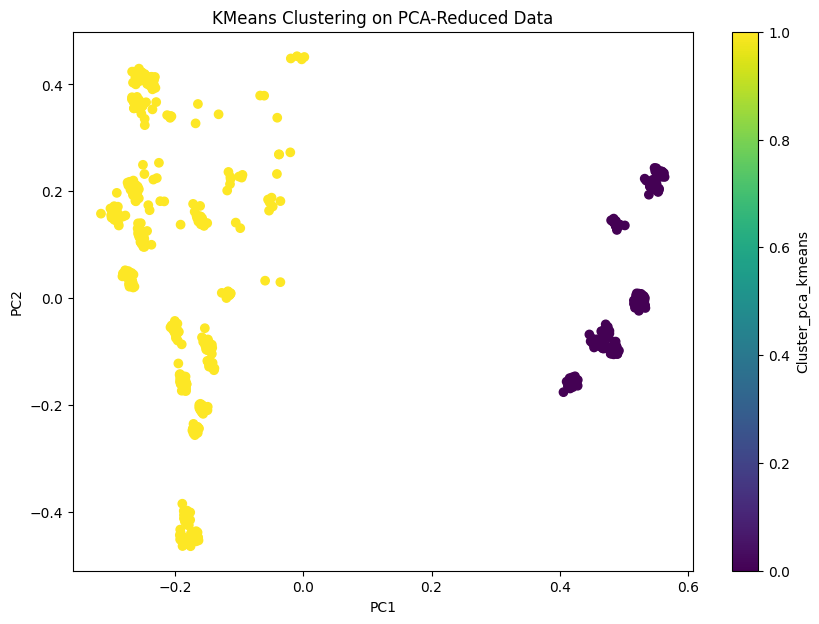

In [44]:
# No difference in the cluster groups, but now we can visualize the clusters in 2 dimensions...
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(df['PC1'], df['PC2'], c=df['cluster_pca_kmeans'], cmap='viridis', marker='o')
plt.title('KMeans Clustering on PCA-Reduced Data')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cluster_pca_kmeans')
plt.show()

In [45]:
# Let's re-try Kmeans clustering, but instead of allowing it to use the default euclidean distance metric
# we will convert the cosine similary vectors to equivalent euclidean distance vectors
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

# Extract the embeddings from the DataFrame
embeddings = df['embedding'].tolist()

# Normalize the embeddings to make the cosine distance equivalent to Euclidean distance
embeddings_normalized = normalize(embeddings)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=0)  # Adjust the number of clusters as needed
df['cluster_kmeans_cosine'] = kmeans.fit_predict(embeddings_normalized)

df.columns

Index(['ID', 'Log Entry', 'embedding', 'cluster_kmeans', 'PC1', 'PC2',
       'cluster_pca_kmeans', 'cluster_kmeans_cosine'],
      dtype='object')

In [46]:
# We hope to see cluster group counts in the ballpark of 950 and 50
df['cluster_kmeans_cosine'].value_counts()

cluster_kmeans_cosine
1    711
0    289
Name: count, dtype: int64

In [47]:
# Let's try a different clustering algorithm...Agglomerative Clustering (hierarchical instead of linear)
from sklearn.cluster import AgglomerativeClustering

# Perform Agglomerative Clustering with the cosine similarity matrix
agg_clustering = AgglomerativeClustering(
    n_clusters=2,  # Adjust the number of clusters as needed
    #affinity='precomputed',  # Use the precomputed cosine similarity matrix...older version scikit-learn
    metric='cosine',  # Newer version of scikit-learn
    linkage='average'  # 'average' linkage is commonly used with cosine distance
)

#df['cluster_agglomerative'] = agg_clustering.fit_predict(1 - cosine_sim_matrix)  # 1 - cosine_similarity to convert similarity to distance
df['cluster_agglomerative'] = agg_clustering.fit_predict(embeddings)  # 1 - cosine_similarity to convert similarity to distance

# Analyze the results
n_clusters = len(set(df['cluster_agglomerative'])) - (1 if -1 in df['cluster_agglomerative'] else 0)
print(f'Estimated number of clusters: {n_clusters}')


Estimated number of clusters: 2


In [48]:
# We hope to see cluster group counts in the ballpark of 950 and 50...still no dice
df['cluster_agglomerative'].value_counts()

cluster_agglomerative
0    711
1    289
Name: count, dtype: int64

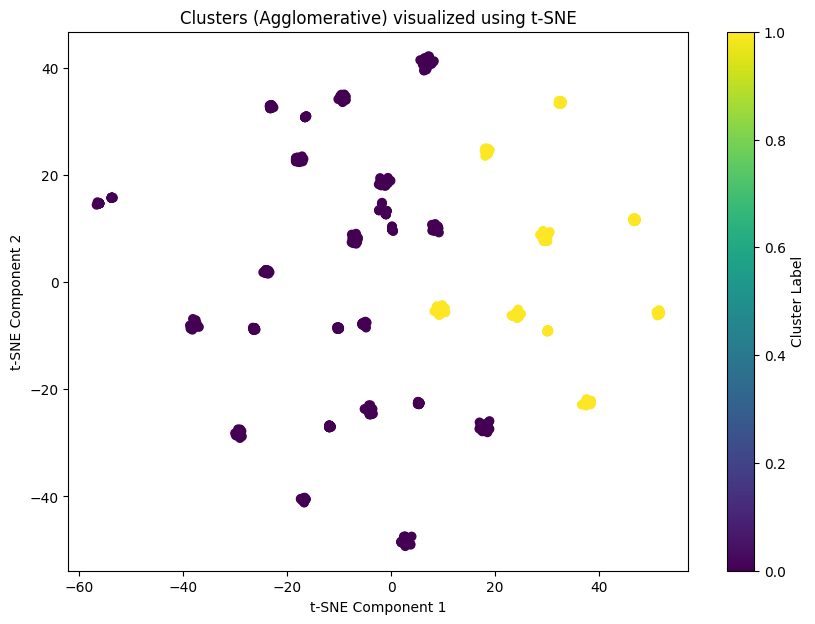

In [49]:
# Let's try using a non-linear stochastic dimensionality reduction (t-SNE), and plot those results
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# DataFrame is named `df` and the embeddings are in a column named 'embedding'
embeddings = np.array(df['embedding'].tolist())


# Let's try reducing dimensions to 2 using non-linear t-SNE instead of linear PCA
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne_2d = tsne.fit_transform(embeddings)

# Plot the t-SNE results
plt.figure(figsize=(10, 7))
plt.scatter(embeddings_tsne_2d[:, 0], embeddings_tsne_2d[:, 1], c=df['cluster_agglomerative'], cmap='viridis', marker='o')
plt.title('Clusters (Agglomerative) visualized using t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster Label')
plt.show()


In [50]:
# Let's try using DBSCAN clustering (non-linear density-based) instead of Kmeans...we'll use cosine distance
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics.pairwise import cosine_distances

# Convert the embeddings column to a numpy array
embeddings = np.array(df['embedding'].tolist())

# Standardize the data (optional but recommended)
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# Calculate the cosine distance matrix
cosine_dist_matrix = cosine_distances(embeddings_scaled)

# Perform DBSCAN clustering with cosine distance
# Parameters to adjust: `eps` (radius of neighborhood), `min_samples` (min points to form a cluster)
dbscan = DBSCAN(eps=0.5, min_samples=5, metric='precomputed')
df['cluster_dbscan'] = dbscan.fit_predict(cosine_dist_matrix)

# Analyzing the results
n_clusters = len(set(df['cluster_dbscan'])) - (1 if -1 in df['cluster_dbscan'] else 0)
n_noise = list(df['cluster_dbscan']).count(-1)

print(f'Estimated number of DBSCAN clusters: {n_clusters}')
print(f'Estimated number of noise points: {n_noise}')

# If you want to see the first few entries and their clusters
df.columns

Estimated number of DBSCAN clusters: 8
Estimated number of noise points: 0


Index(['ID', 'Log Entry', 'embedding', 'cluster_kmeans', 'PC1', 'PC2',
       'cluster_pca_kmeans', 'cluster_kmeans_cosine', 'cluster_agglomerative',
       'cluster_dbscan'],
      dtype='object')

In [51]:
# We hope to see cluster group counts in the ballpark of 950 and 50
df['cluster_dbscan'].value_counts()

# It appears that perhaps cluster 2 with 53 points might be our malicious logs, but...
# I'm not sure (yet) how we would determine that if we didn't already there were 50 bad logs

cluster_dbscan
5    289
1    182
6    142
0    138
3     95
4     86
2     53
7     15
Name: count, dtype: int64

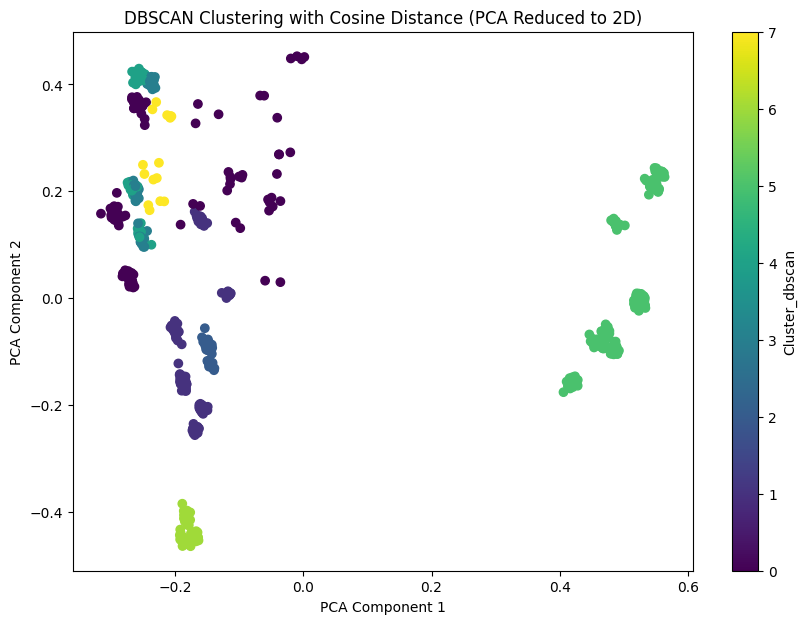

In [52]:
# Plot the results after applying PCA

# Reduce the embeddings to 2 dimensions using PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=df['cluster_dbscan'], cmap='viridis', marker='o')
plt.title('DBSCAN Clustering with Cosine Distance (PCA Reduced to 2D)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Cluster_dbscan')
plt.show()

I think we've found the cluster group with the bad logs...DBSCAN found the group with 53 members, and I suspect it's the light green group.  

I think we can call this exercise complete...it's not really productive to dig any deeper with fake data.  However,I think we've seen a good sample of how to do semantic clustering analysis with full-text data. 

# Where do we go from here?
Some areas for further research:
- It's worth noting that the semantic matching and non-matching were very good.  However, the clustering was not what we expected.  Perhaps we should try different embedding models to determine which one performs best with proxy logs...the one we used is very generic, one finetuned on event logs or specifically on cybersecurity data content might produce much better clustering results.  One larger and more resource-heavy embedding was examined (see the commented-out calls in the clustering section)...the clustering results were the same or slightly less clear. Again, this is fabricated data, so that might be a big part of the unexpected clustering results.
- Dig deeper into the data to determine how we would be able to name the clusters proposed by DBSCAN (with real data, not worthwhile with fake data).
- Examine other clustering algorithms that might be more meaningful (with real data, not worthwhile with fake data). We've examined Kmeans w/ and w/o PCA, DBSCAN, and Agglomerative...there might be other algorithms to examine to get clear results with real data. This is a fairly unexplored area currently.
